It is a simple tutorial on how to train classifiers with a selection of an optimal set of features. All necessary code is implemented in <B>clfga</B> library

See details in the paper

Zelenkov, Y., Fedorova, E., & Chekrizov, D. (2017). Two-step classification method based on genetic algorithm for bankruptcy forecasting. <I>Expert Systems with Applications</I>, 88, 393-401.

<B>Note!</B> If you find this code useful and will use it for preparing your publication, please cite the paper above.

In [3]:
%matplotlib inline
import clfga as cga
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.datasets import make_classification
from sklearn import preprocessing
from time import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Create a classification problem
number_of_features = 20

X,y = make_classification(n_samples = 500, n_features = number_of_features, n_informative = 5, n_redundant = 5, n_repeated = 2)
print(X.shape, y.shape)

# Normilize 

max_abs_scaler = preprocessing.MaxAbsScaler()
X = max_abs_scaler.fit_transform(X)

# Divide the training and test datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(500, 20) (500,)
(400, 20) (400,)
(100, 20) (100,)


Here we use the classifiers implemented in learn the <B>skleran</B> library. The correspondence of aliases to real calls can be seen in the function <I>calc_fitness</I> in <I>clfga</I>.

I've realized the calls of base classifiers directly in <I>clfga</I> library, so to call a particular classifier you should only point its alis as in <I>clf_set</I> below. If it is not convenient, you should modify method <I>calc_fitness</I> of <I>Classifier</I> object.

In [5]:
# Create set of classifiers

clf_set = ('knn','lr','nb', 'dt', 'svm','lda','qda') # 'rf','et','mlp' - other possible classiefiers

Function <I>EvolveClf</I>, that realized in library <I>clfga</I>, trains classifier selecting optimal set of features using genetic algorithm

Information that is printed during training:
 - alias of classifier
 - start - accuracy on full set of features
 - fin - accuracy after selection optimal features (variation computed during cross validation)
 - features - number of selected features
 - pre/rec - precision / recall on dataset with selected features
 - (time of training)

In [6]:
# Train classifiers with feature selection

pop_size = 50
generations = 50
prob_of_crossover = 0.5

fitness = []
setOfClf = []

for clf_type in clf_set:
    start = time()
    fitness_story, bi = cga.EvolveClf (clf_type,number_of_features,pop_size,generations,prob_of_crossover,X_train,y_train)
    end = time()
    print('%3s: accuracy start = %5.3f fin = %5.3f (+/- %5.3f) features = %2d prec/rec = %5.3f/%5.3f (%4.1f sec)' 
            %(clf_type,fitness_story[0],bi.accuracy,bi.std * 2,bi.n_features,bi.precision,bi.recall,end-start))
    fitness.append(fitness_story)
    setOfClf.append(bi)

knn: accuracy start = 0.762 fin = 0.892 (+/- 0.033) features =  9 prec/rec = 0.924/0.854 (48.5 sec)
 lr: accuracy start = 0.765 fin = 0.775 (+/- 0.023) features = 10 prec/rec = 0.794/0.744 (43.7 sec)
 nb: accuracy start = 0.795 fin = 0.825 (+/- 0.071) features = 14 prec/rec = 0.816/0.844 (33.9 sec)
 dt: accuracy start = 0.820 fin = 0.855 (+/- 0.073) features =  9 prec/rec = 0.852/0.859 (30.7 sec)
svm: accuracy start = 0.765 fin = 0.790 (+/- 0.073) features =  9 prec/rec = 0.786/0.799 (51.6 sec)
lda: accuracy start = 0.765 fin = 0.780 (+/- 0.050) features = 16 prec/rec = 0.775/0.799 (40.3 sec)
qda: accuracy start = 0.553 fin = 0.832 (+/- 0.072) features =  7 prec/rec = 0.805/0.879 (33.9 sec)


Text(0,0.5,'accuracy')

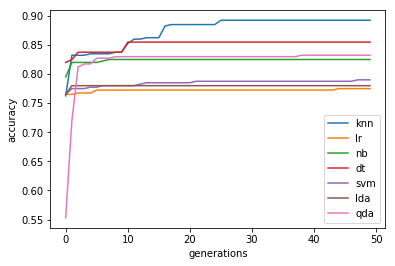

In [7]:
# Now we can plot the story of training 

for i in range(0,len(fitness)):
    plt.plot(fitness[i],label= clf_set[i])
plt.legend(loc = "lower right")
plt.xlabel('generations')
plt.ylabel('accuracy')

In [8]:
# Let check quality on test dataset

from sklearn.metrics import accuracy_score,precision_score,recall_score
print('Accuracy of prediction on test sample:')
print('     acc   pre   rec')
for clf in setOfClf:
    X = np.copy(X_test)
    y = np.copy(y_test)
    for i in range(0,len(clf.genome)):
        if clf.genome[len(clf.genome)-1-i] == 0:
            X = np.delete(X,len(clf.genome)-1-i,1)
    p = clf.clf.predict(X)
    print('%3s: %5.3f %5.3f %5.3f' %(clf.type,accuracy_score(y,p),precision_score(y,p),recall_score(y,p)))

Accuracy of prediction on test sample:
     acc   pre   rec
knn: 0.920 0.978 0.865
 lr: 0.770 0.822 0.712
 nb: 0.830 0.857 0.808
 dt: 0.840 0.875 0.808
svm: 0.780 0.826 0.731
lda: 0.740 0.771 0.712
qda: 0.790 0.816 0.769


In [9]:
# What features are selected?

feature_names = []
for i in range(0,number_of_features):
    feature_names.append('f_'+str(i))

s = "feature"
for i in range(0,len(clf_set)):
    s += " " + '{:3s}'.format(clf_set[i])
s = s + ' Total'
print(s)
for i in range(0,number_of_features):
    s = '{:4s}'.format(feature_names[i]) + '   '
    k = 0
    for c in setOfClf:
        k = k + c.genome[i]
        s = s + '   ' + str(c.genome[i])
    s = s + '   '+ str(k)
    print(s)

feature knn lr  nb  dt  svm lda qda Total
f_0       1   1   0   1   0   1   0   4
f_1       1   0   0   0   0   1   0   2
f_2       1   0   1   0   1   1   0   4
f_3       0   0   1   1   0   1   0   3
f_4       0   0   0   0   0   0   0   0
f_5       1   1   1   0   0   1   1   5
f_6       1   1   1   0   1   0   0   4
f_7       0   0   1   1   0   0   1   3
f_8       1   1   1   1   1   1   0   6
f_9       0   1   1   0   1   1   0   4
f_10      1   0   1   1   0   1   1   5
f_11      0   1   0   0   1   1   1   4
f_12      0   1   0   0   0   1   0   2
f_13      0   0   0   1   0   0   1   2
f_14      0   0   1   0   1   1   0   3
f_15      0   1   1   0   1   1   0   4
f_16      1   0   1   1   0   1   0   4
f_17      1   1   1   1   1   1   1   7
f_18      0   0   1   1   0   1   1   4
f_19      0   1   1   0   1   1   0   4
